In [48]:
import numpy as np
from scipy import signal
import os
import cv2
from keras.utils import to_categorical





In [49]:
class Layer:
    def __init__(self): #intialize the layer with input and output attriutes
        self.input = None
        self.output = None

    def forward(self, input): #forward propogation
        # TODO: return output
        pass

    def backward(self, output_gradient, learning_rate): #backward propogation
        # TODO: update parameters and return input gradient
        pass

In [50]:
class Dense(Layer):
    def __init__(self, input_size, output_size): #Intialize dense layer with weights and biases 
        self.weights = np.random.randn(output_size, input_size)
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input): #forward propogation for a dense layer
        self.input = input
        return np.dot(self.weights, self.input) + self.bias

    def backward(self, output_gradient, learning_rate): #backward propogation for  dense layer
        weights_gradient = np.dot(output_gradient, self.input.T)
        input_gradient = np.dot(self.weights.T, output_gradient)
        self.weights -= learning_rate * weights_gradient #update weights and biases
        self.bias -= learning_rate * output_gradient
        return input_gradient

In [51]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth): #Initialize convolutional layer parameters
        input_depth, input_height, input_width = input_shape
        self.depth = depth
        self.input_shape = input_shape
        self.input_depth = input_depth
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)
        self.kernels = np.random.randn(*self.kernels_shape)
        self.biases = np.random.randn(*self.output_shape)

    def forward(self, input): #forward propogation for convolutional layer
        self.input = input
        self.output = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.input_depth):
                self.output[i] += signal.correlate2d(self.input[j], self.kernels[i, j], "valid")
        return self.output

    def backward(self, output_gradient, learning_rate): #backward propogation for convolutional layer
        kernels_gradient = np.zeros(self.kernels_shape)
        input_gradient = np.zeros(self.input_shape)

        for i in range(self.depth):
            for j in range(self.input_depth):
                kernels_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        self.kernels -= learning_rate * kernels_gradient
        self.biases -= learning_rate * output_gradient
        return input_gradient


In [52]:
class Reshape(Layer): #Initialize reshape layer with input and output shapes
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input): #reshape the input data to the specified output shape
        return np.reshape(input, self.output_shape)

    def backward(self, output_gradient, learning_rate): #reshape the output gradient to the input shape
        return np.reshape(output_gradient, self.input_shape)

In [53]:
class Activation(Layer): #initialize activation layer with activation function and it's derivatives
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input): #apply activation function to input data
        self.input = input
        return self.activation(self.input)

    def backward(self, output_gradient, learning_rate): #apply derivative of activation function to output data 
        return np.multiply(output_gradient, self.activation_prime(self.input))

In [54]:
class Tanh(Activation):
    def __init__(self):
        def tanh(x):#Tanh activation function and it's derivatives
            return np.tanh(x)

        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2

        super().__init__(tanh, tanh_prime)

class Sigmoid(Activation): #Sigmoid activation function and it's derivatives
    def __init__(self):
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))

        def sigmoid_prime(x):
            s = sigmoid(x)
            return s * (1 - s)

        super().__init__(sigmoid, sigmoid_prime)

class Softmax(Layer): #Apply softmax function to input data
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp / np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # This version is faster than the one presented in the video
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

In [55]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)

def binary_cross_entropy(y_true, y_pred):
    return np.mean(-y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / np.size(y_true)


In [56]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

def train(network, loss, loss_prime, x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
    for e in range(epochs):
        error = 0
        for x, y in zip(x_train, y_train):
            # forward
            output = predict(network, x)

            # error
            error += loss(y, output)

            # backward
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        if verbose:
            print(f"{e + 1}/{epochs}, error={error}")

In [57]:
def load_and_preprocess(folder_path, label, reshaped_size):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Assuming images are in JPG format
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img_resized = cv2.resize(img, (reshaped_size, reshaped_size))
            images.append(img_resized.flatten())
            labels.append(label)

    return np.array(images), np.array(labels)

def preprocess_data(folder_paths, reshaped_size=64):
    images_with_mask, labels_with_mask = load_and_preprocess(folder_paths[0], label=1, reshaped_size=reshaped_size)
    images_without_mask, labels_without_mask = load_and_preprocess(folder_paths[1], label=0, reshaped_size=reshaped_size)

    all_images = np.vstack((images_with_mask, images_without_mask))
    all_labels = np.hstack((labels_with_mask, labels_without_mask))

    indices = np.random.permutation(len(all_images))
    all_images, all_labels = all_images[indices], all_labels[indices]

    x_data = all_images.reshape(len(all_images), 1, reshaped_size, reshaped_size).astype("float32") / 255
    y_data = to_categorical(all_labels, num_classes=2).reshape(len(all_labels), 2, 1)



    return x_data, y_data



In [58]:
# Define your folder paths
folder_paths = ["./data/with_mask", "./data/without_mask"]

# Load and preprocess your custom dataset
X, Y = preprocess_data(folder_paths, reshaped_size=64)
# Set the proportion for training data
train_proportion = 0.8
num_samples = len(X)

# Calculate the number of samples for training
num_train = int(train_proportion * num_samples)

# Split the data
X_train, y_train = X[:num_train], Y[:num_train]
X_test, y_test = X[num_train:], Y[num_train:]

In [62]:
network = [
    Convolutional((1, 64, 64), 3, 5),
    Sigmoid(),
    Reshape((5, 62, 62), (5 * 62 * 62, 1)),
    Dense(5 * 62 * 62, 256),
    Sigmoid(),
    Dense(256, 2),
    Sigmoid()
]

# Train the network
train(
    network,
    binary_cross_entropy,
    binary_cross_entropy_prime,
    X_train,
    y_train,
    epochs=50,
    learning_rate=0.01)

1/50, error=0.7999421973112473
2/50, error=0.722432981973242
3/50, error=0.717540901242202
4/50, error=0.7064754141653095
5/50, error=0.7129919402146738
6/50, error=0.7204976931788674
7/50, error=0.7074603377637076
8/50, error=0.7112688253523706
9/50, error=0.718531932606958
10/50, error=0.7207053462677052
11/50, error=0.7173554689622206
12/50, error=0.7148016820762226
13/50, error=0.7053386592804562
14/50, error=0.6984867686282464
15/50, error=0.7119058463345711
16/50, error=0.7014617074743766
17/50, error=0.6921884011976371
18/50, error=0.676246098949474
19/50, error=0.6956409726228436
20/50, error=0.6927198443338849
21/50, error=0.6891726172557643
22/50, error=0.6772078491906287
23/50, error=0.6847480787814905
24/50, error=0.6784496555899212
25/50, error=0.6703665173125658
26/50, error=0.6826378822500618
27/50, error=0.6672175996918323
28/50, error=0.6687874015329103
29/50, error=0.6721082985641273
30/50, error=0.680145388409452
31/50, error=0.6624366247654764
32/50, error=0.6617413

In [63]:
def calculate_accuracy(network, x, y):
    correct_predictions = 0

    for i in range(len(x)):
        output = predict(network, x[i])
        predicted_label = np.argmax(output)
        true_label = np.argmax(y[i])

        if predicted_label == true_label:
            correct_predictions += 1

    accuracy = correct_predictions / len(x)
    return accuracy


In [64]:
# Calculate and print accuracy on the training set
train_accuracy = calculate_accuracy(network, X_train, y_train)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.6525984773253889


In [66]:
for x, y in zip(X_test, y_test):
    output = predict(network, x)
    print(f"pred: {np.argmax(output)}, true: {np.argmax(y)}")

pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 0, true: 1
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 1
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 1
pred: 0, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 0, true: 1
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 0
pred: 1, true: 1
pred: 1, true: 0
pred: 0, true: 0
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 1, true: 1
pred: 0, true: 0
pred: 0, true: 0
pred: 0, true:

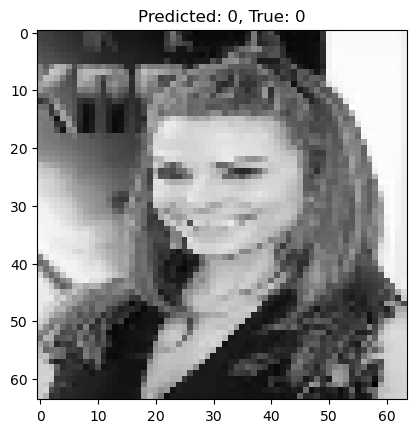

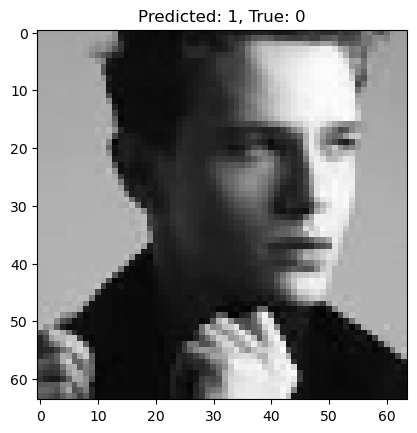

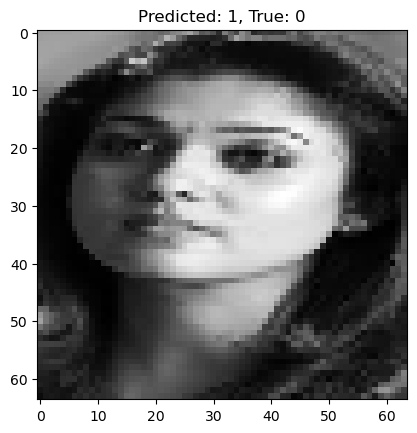

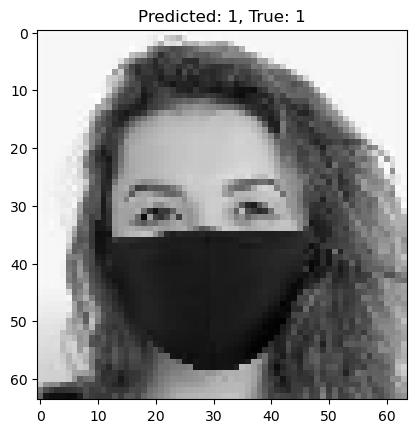

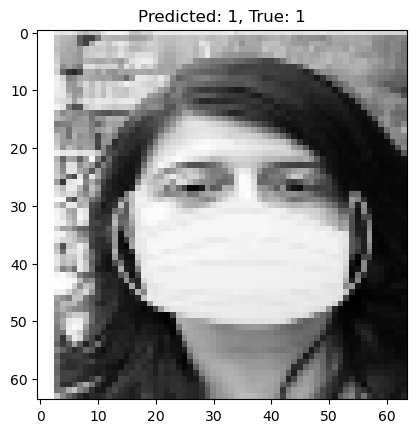

In [67]:
import random
import matplotlib.pyplot as plt

# Assuming X_test is a list of images and y_test is a list of labels

# Select a random subset of images
sample_indices = random.sample(range(len(X_test)), 5)

for index in sample_indices:
    x = X_test[index]
    y = y_test[index]

    # Make a prediction
    output = predict(network, x)

    # Display the image
    plt.imshow(x.reshape(64, 64), cmap='gray')
    plt.title(f"Predicted: {np.argmax(output)}, True: {np.argmax(y)}")
    plt.show()
